In [1]:
suppressPackageStartupMessages({
library(Seurat)
library(cowplot)
library(Matrix)
library(dplyr)
library(future)
library(ggplot2)
library(reshape2)
library(tictoc)
library(DoubletFinder)
library(SingleR)
})

In [6]:
DoubletRemovalParameters <- function(seu, PCs=1:30, use.SCT=FALSE, num.cores=1, quietly=TRUE){
    tic("sweep parameters")
    # calculate parameters
    if (quietly==TRUE){
        invisible(capture.output(sweep.res.list <- paramSweep_v3(seu, PCs = PCs, sct=use.SCT, num.cores=num.cores)))
        invisible(capture.output(sweep.stats    <- summarizeSweep(sweep.res.list, GT = FALSE)))
        ff <- tempfile()
        png(filename=ff)
        invisible(capture.output(bcmvn <- find.pK(sweep.stats)))
        dev.off()
        unlink(ff)
    }else{
        sweep.res.list <- paramSweep_v3(seu, PCs = PCs, sct=use.SCT, num.cores=num.cores)
        sweep.stats    <- summarizeSweep(sweep.res.list, GT = FALSE)
        ff <- tempfile()
        png(filename=ff)
        bcmvn <- find.pK(sweep.stats)
        dev.off()
        unlink(ff)
    }
    toc()
    # choose parameters
    maxBCmetric    <- max(bcmvn$BCmetric, na.rm = TRUE)
    pK.maxBCmetric <- as.numeric(as.character(bcmvn[bcmvn$BCmetric==maxBCmetric, ]$pK))
    return(list(pK=pK.maxBCmetric, bcmvn=bcmvn))
}

bcmvnPlot<-function(bcmvn, maxpos=0.08){
    data<-data.frame(pK   =as.numeric(as.character(bcmvn$pK)),
                     BCmvn=as.numeric(as.character(bcmvn$BCmetric)))
    ggplot(data=data, aes(x=pK, y=BCmvn)) +
    geom_point(color = "#20639B")+geom_line(color = "#3CAEA3")+
    theme(axis.text.x = element_text(angle = 45,size=6, hjust = 1))+ 
    scale_x_continuous(name="pK", limits = c(0.00,0.3),
        breaks=c(0.001,0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,
                 0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,
                 0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3))+
    geom_vline(xintercept = maxpos, linetype="dashed", color = "red", size=0.5)->plot
    plot
}

DoubletRemoval <-function(seu, identity, pK, doublet.rate, pN=0.25, PCs=1:30, use.SCT=FALSE){
    # compute doublet scores
    tic("Removing doublets")
    annotations    <- seu@meta.data$identity  ## ex: annotations <- seu_kidney@meta.data$ClusteringResults
    homotypic.prop <- modelHomotypic(annotations) 
    nExp_poi       <- round(doublet.rate*length(colnames(x = seu)))  ## Assuming 7.5% doublet formation rate - tailor for your dataset
    nExp_poi.adj   <- round(nExp_poi*(1-homotypic.prop))
    seu.scored     <- doubletFinder_v3(seu, PCs =PCs, pN = pN, pK = pK, nExp = nExp_poi.adj, reuse.pANN = FALSE, sct = use.SCT)
    toc()
    
    # pick out doublets
    cname <-colnames(seu.scored[[]])
    DF<-cname[grep('^DF',cname)] 
    seu.scored[["doublet"]] <- as.numeric(seu.scored[[DF]]=="Doublet")

    # remove doublets
    seu.removed <- subset(seu.scored, subset = doublet != 1)
    return(list(removed=seu.removed, original=seu.scored))
}

# Load datasets 

here we load each dataset (wti,wtc,koi,koc) and do NOT integrate them

we are going to conduct a series of quality check steps in coming codes

In [2]:
tic()
wti.data <- Read10X(data.dir ="/Users/yzhou14/Data_local/20191010_scRNAseq_analysis/Raw_Data/WTI/")
wtc.data <- Read10X(data.dir ="/Users/yzhou14/Data_local/20191010_scRNAseq_analysis/Raw_Data/WTC/")
koi.data <- Read10X(data.dir ="/Users/yzhou14/Data_local/20191010_scRNAseq_analysis/Raw_Data/C3KOI/")
koc.data <- Read10X(data.dir ="/Users/yzhou14/Data_local/20191010_scRNAseq_analysis/Raw_Data/C3KOC/")
toc()

62.584 sec elapsed


In [4]:
tic()

#Set up first object
wti <- CreateSeuratObject(counts = wti.data, project = "WILD_TYPE", min.cells = 3)
wti[["percent.mt"]] <- PercentageFeatureSet(wti, pattern = "^mt-")
wti <- subset(wti, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 25)
wti$stim <- "WTI"


# Set up second object
wtc <- CreateSeuratObject(counts = wtc.data, project = "WILD_TYPE", min.cells = 3)
wtc[["percent.mt"]] <- PercentageFeatureSet(wtc, pattern = "^mt-")
wtc <- subset(wtc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 25)
wtc$stim <- "WTC"


# Set up third object
koi <- CreateSeuratObject(counts = koi.data, project = "GEMM", min.cells = 3)
koi[["percent.mt"]] <- PercentageFeatureSet(koi, pattern = "^mt-")
koi <- subset(koi, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 25)
koi$stim <- "KOI"


# Set up fourth object
koc <- CreateSeuratObject(counts = koc.data, project = "GEMM", min.cells = 3)
koc[["percent.mt"]] <- PercentageFeatureSet(koc, pattern = "^mt-")
koc <- subset(koc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 25)
koc$stim <- "KOC"

toc()

945.611 sec elapsed


In [7]:
tic("Renormalization and Dimensionality reduction")
seu  <- wti
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
seu  <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
seu  <- RunPCA(seu,  npcs=50, features=VariableFeatures(object=seu),  verbose = FALSE)
seu  <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L) 
seu  -> wti
toc()

tic("Renormalization and Dimensionality reduction")
seu  <- wtc
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
seu  <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
seu  <- RunPCA(seu,  npcs=50, features=VariableFeatures(object=seu),  verbose = FALSE)
seu  <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L) 
seu  -> wtc
toc()

tic("Renormalization and Dimensionality reduction")
seu  <- koi
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
seu  <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
seu  <- RunPCA(seu,  npcs=50, features=VariableFeatures(object=seu),  verbose = FALSE)
seu  <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L) 
seu  -> koi
toc()

tic("Renormalization and Dimensionality reduction")
seu  <- koc
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
seu  <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
seu  <- RunPCA(seu,  npcs=50, features=VariableFeatures(object=seu),  verbose = FALSE)
seu  <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L) 
seu  -> koc
toc()

Centering and scaling data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Renormalization and Dimensionality reduction: 23.073 sec elapsed


Centering and scaling data matrix



Renormalization and Dimensionality reduction: 23.13 sec elapsed


Centering and scaling data matrix



Renormalization and Dimensionality reduction: 9.793 sec elapsed


Centering and scaling data matrix



Renormalization and Dimensionality reduction: 18.478 sec elapsed


In [8]:
wti <- FindNeighbors(wti, reduction = "pca", dims = 1:30)
wti <- FindClusters( wti, resolution = 0.5)

wtc <- FindNeighbors(wtc, reduction = "pca", dims = 1:30)
wtc <- FindClusters( wtc, resolution = 0.5)

koi <- FindNeighbors(koi, reduction = "pca", dims = 1:30)
koi <- FindClusters( koi, resolution = 0.5)

koc <- FindNeighbors(koc, reduction = "pca", dims = 1:30)
koc <- FindClusters( koc, resolution = 0.5)


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4461
Number of edges: 188809

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8454
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4734
Number of edges: 189688

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8525
Number of communities: 10
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1341
Number of edges: 46527

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8741
Number of communities: 9
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3503
Number of edges: 136011

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8886
Number of communities: 12
Elapsed time: 0 seconds


# Doublet score evaluation

## Doublet algorithm parameter selection

In [11]:
tic()
wti.bcmvn=DoubletRemovalParameters(wti, PCs=1:30, use.SCT=FALSE, num.cores=1, quietly=TRUE)
toc()
tic()
wtc.bcmvn=DoubletRemovalParameters(wtc, PCs=1:30, use.SCT=FALSE, num.cores=1, quietly=TRUE)
toc()
tic()
koi.bcmvn=DoubletRemovalParameters(koi, PCs=1:30, use.SCT=FALSE, num.cores=1, quietly=TRUE)
toc()
tic()
koc.bcmvn=DoubletRemovalParameters(koc, PCs=1:30, use.SCT=FALSE, num.cores=1, quietly=TRUE)
toc()

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:stats4’:

    mle


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: maps

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Loading required pack

sweep parameters: 230.034 sec elapsed
230.07 sec elapsed


Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”

sweep parameters: 197.076 sec elapsed
197.082 sec elapsed


Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”

sweep parameters: 51.542 sec elapsed
51.546 sec elapsed


Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”
Warning message in axis(side = side, at = at, labels = labels, ...):
“no font could be found for family "Arial"”

sweep parameters: 134.759 sec elapsed
134.764 sec elapsed


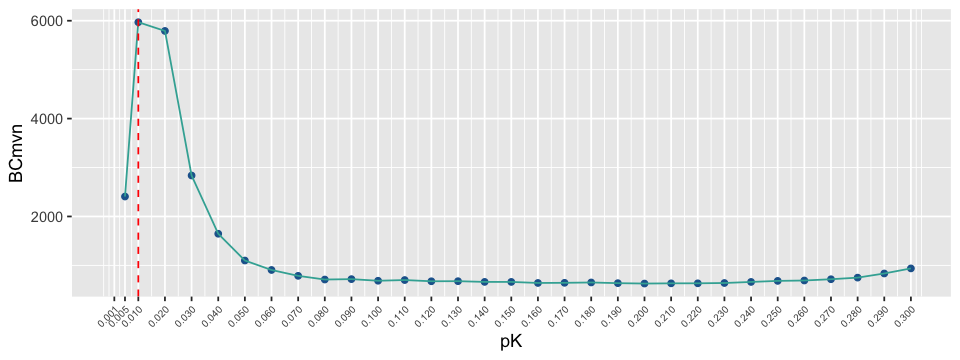

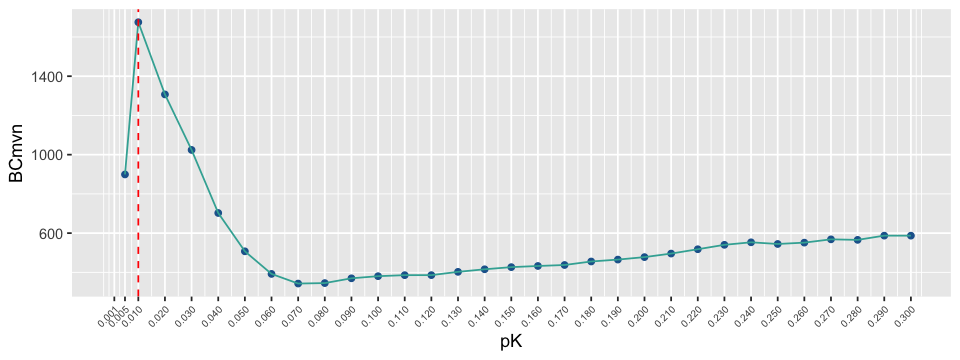

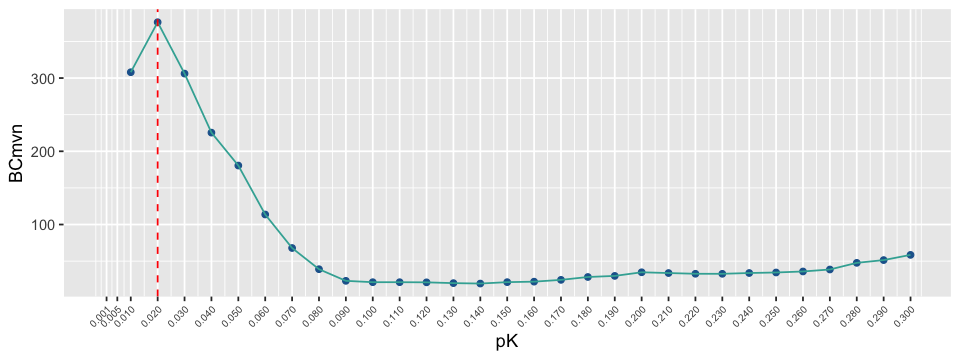

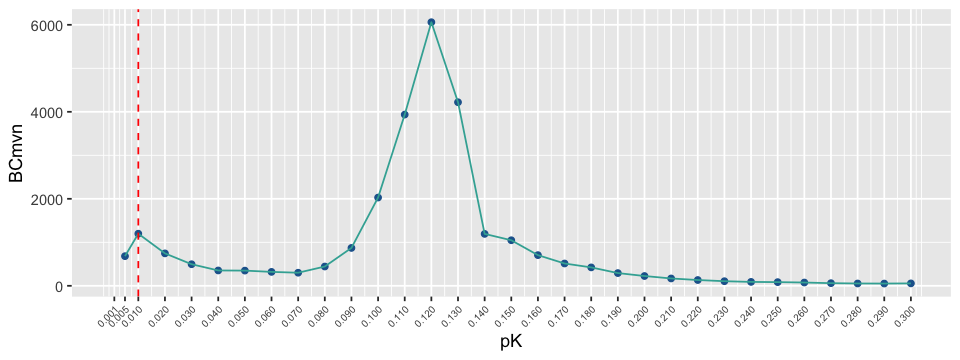

In [10]:
options(repr.plot.height=3, repr.plot.width=8)
bcmvnPlot(wti.bcmvn$bcmvn, maxpos = 0.01)
bcmvnPlot(wtc.bcmvn$bcmvn, maxpos = 0.01)
bcmvnPlot(koi.bcmvn$bcmvn, maxpos = 0.02)
bcmvnPlot(koc.bcmvn$bcmvn, maxpos = 0.01)

We found the following pKs for doublet score evaluation:

- WTI: 0.01
- WTC: 0.01
- KOI: 0.02 
- KOC: 0.01

Note that KOC sample have a pK peak at 0.12, but larger pK usually raise false positives, we chose a local maximum value at 0.02

In [46]:
tic()
save.image(file="doublet_step1.tmp.rda", compress=T)
toc()

122.857 sec elapsed


## doublet rate estimation

In [13]:
print(nrow(wti[[]]))
print(nrow(wtc[[]]))
print(nrow(koi[[]]))
print(nrow(koc[[]]))

[1] 4461
[1] 4734
[1] 1341
[1] 3503


According to 10x Genomics' data, the doublet rate is round %1/1kCells.
We here by estimate our doublet rates as follow:

- WTI: 4.5%
- WTC: 4.5%
- KOI: 1.5%
- KOC: 3.5%

## Compute doublet scores

In [14]:
tic()
wti.df<-DoubletRemoval(seu=wti, identity="RNA_snn_res.0.5", pK=0.01, doublet.rate=0.045, 
                       pN=0.25, PCs=1:30, use.SCT=FALSE)
toc()

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:stats4’:

    mle


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: maps

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



[1] "Creating 1487 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
Removing doublets: 37.993 sec elapsed
38.84 sec elapsed


In [15]:
tic()
wtc.df<-DoubletRemoval(seu=wtc, identity="RNA_snn_res.0.5", pK=0.01, doublet.rate=0.045, 
                       pN=0.25, PCs=1:30, use.SCT=FALSE)
toc()

[1] "Creating 1578 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
Removing doublets: 33.22 sec elapsed
34.152 sec elapsed


In [16]:
tic()
koi.df<-DoubletRemoval(seu=koi, identity="RNA_snn_res.0.5", pK=0.02, doublet.rate=0.015, 
                       pN=0.25, PCs=1:30, use.SCT=FALSE)
toc()

[1] "Creating 447 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
Removing doublets: 9.784 sec elapsed
10.103 sec elapsed


In [17]:
tic()
koc.df<-DoubletRemoval(seu=koc, identity="RNA_snn_res.0.5", pK=0.01, doublet.rate=0.035, 
                       pN=0.25, PCs=1:30, use.SCT=FALSE)
toc()

[1] "Creating 1168 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
Removing doublets: 23.008 sec elapsed
23.748 sec elapsed


## Display doublet scores

In [39]:
head(koc.df$original[[]])

orig.ident nCount_RNA nFeature_RNA percent.mt stim
AAACCCAAGAGCAGAA-1 GEMM       2063       842           8.870577  KOC 
AAACCCAAGCGACTTT-1 GEMM       1297       587          17.501928  KOC 
AAACCCACAGGTCAAG-1 GEMM       1316       670           4.863222  KOC 
AAACCCATCCCAGGAC-1 GEMM       2540       797           4.409449  KOC 
AAACGAACAACCAACT-1 GEMM        990       600           3.333333  KOC 
AAACGAACACGAAAGC-1 GEMM        676       427           2.366864  KOC 
                   RNA_snn_res.0.5 seurat_clusters pANN_0.25_0.01_123
AAACCCAAGAGCAGAA-1 4               4               0.00000000        
AAACCCAAGCGACTTT-1 2               2               0.04255319        
AAACCCACAGGTCAAG-1 4               4               0.00000000        
AAACCCATCCCAGGAC-1 7               7               0.10638298        
AAACGAACAACCAACT-1 3               3               0.06382979        
AAACGAACACGAAAGC-1 5               5               0.00000000        
                   DF.classifications_0.25_0.01_123 doublet
AAACCCAAGAGCAGAA-1 Singlet                          0      
AAACCCAAGCGACTTT-1 Singlet                          0      
AAACCCACAGGTCAAG-1 Singlet                          0      
AAACCCATCCCAGGAC-1 Singlet                          0      
AAACGAACAACCAACT-1 Singlet                          0      
AAACGAACACGAAAGC-1 Singlet                          0

In [40]:
wti.df$original[["DF"]]<-wti.df$original[["DF.classifications_0.25_0.01_201"]]
wtc.df$original[["DF"]]<-wtc.df$original[["DF.classifications_0.25_0.01_213"]]
koi.df$original[["DF"]]<-koi.df$original[["DF.classifications_0.25_0.02_20"]]
koc.df$original[["DF"]]<-koc.df$original[["DF.classifications_0.25_0.01_123"]]

In [42]:
wti<-wti.df$original
wtc<-wtc.df$original
koi<-koi.df$original
koc<-koc.df$original

In [179]:
wti[["doublet"]]<-wti[[grep("^pANN_",colnames(wti@meta.data), value = T)]]
wtc[["doublet"]]<-wtc[[grep("^pANN_",colnames(wtc@meta.data), value = T)]]
koi[["doublet"]]<-koi[[grep("^pANN_",colnames(koi@meta.data), value = T)]]
koc[["doublet"]]<-koc[[grep("^pANN_",colnames(koc@meta.data), value = T)]]

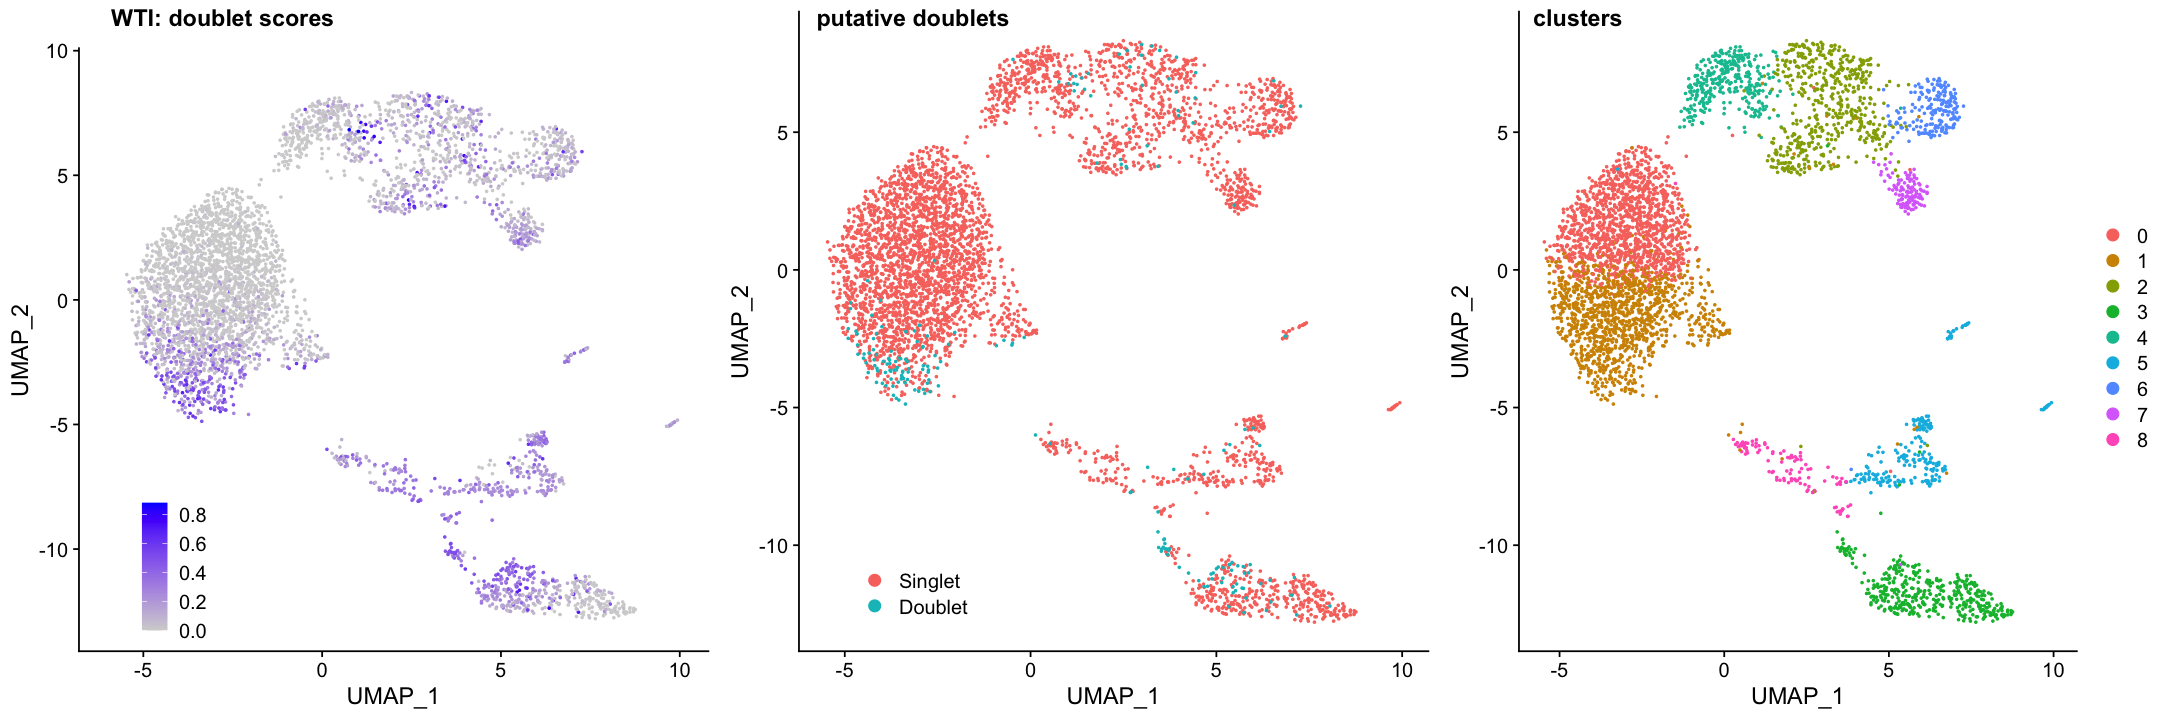

In [180]:
options(repr.plot.width=18, repr.plot.height=6)
plot_grid(
    FeaturePlot(wti, features = "doublet")+ggtitle("")+theme(legend.position = c(0.1,0.15)),
    DimPlot(wti, group.by="DF",order="Doublet")+theme(legend.position = c(0.1,0.1)),
    DimPlot(wti, group.by="RNA_snn_res.0.5"),
    labels=c("WTI: doublet scores","putative doublets","     clusters"),ncol=3
)

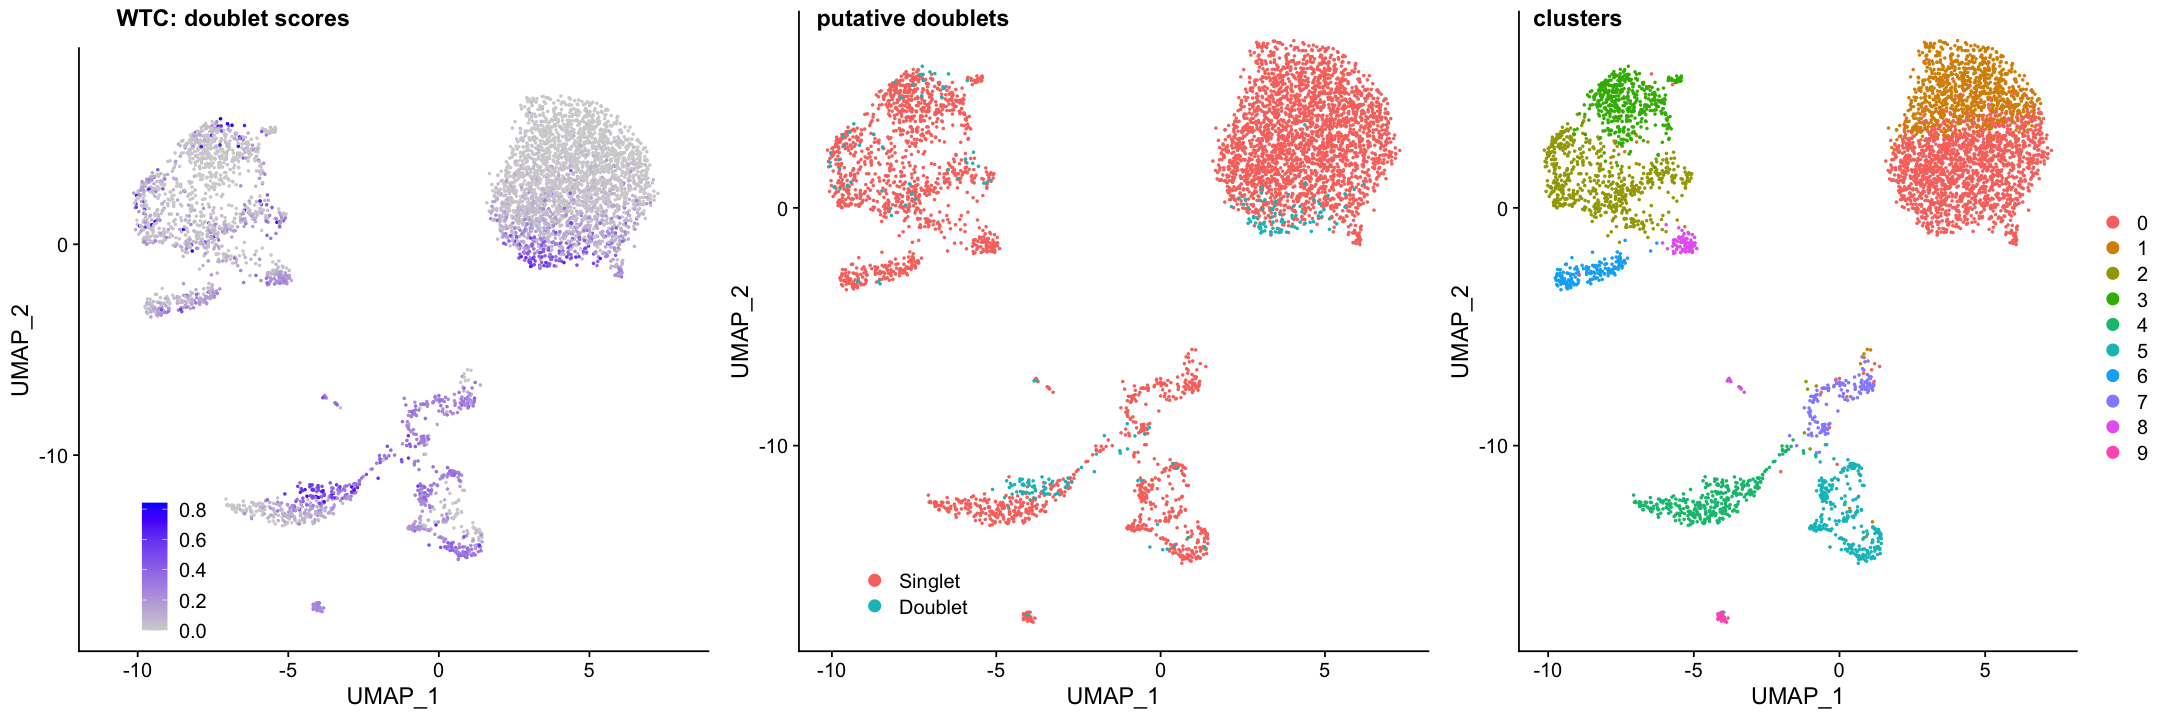

In [181]:
options(repr.plot.width=18, repr.plot.height=6)
plot_grid(
    FeaturePlot(wtc, features = "doublet")+ggtitle("")+theme(legend.position = c(0.1,0.15)),
    DimPlot(wtc, group.by="DF",order="Doublet")+theme(legend.position = c(0.1,0.1)),
    DimPlot(wtc, group.by="RNA_snn_res.0.5"),
    labels=c("WTC: doublet scores","putative doublets","     clusters"),ncol=3
)

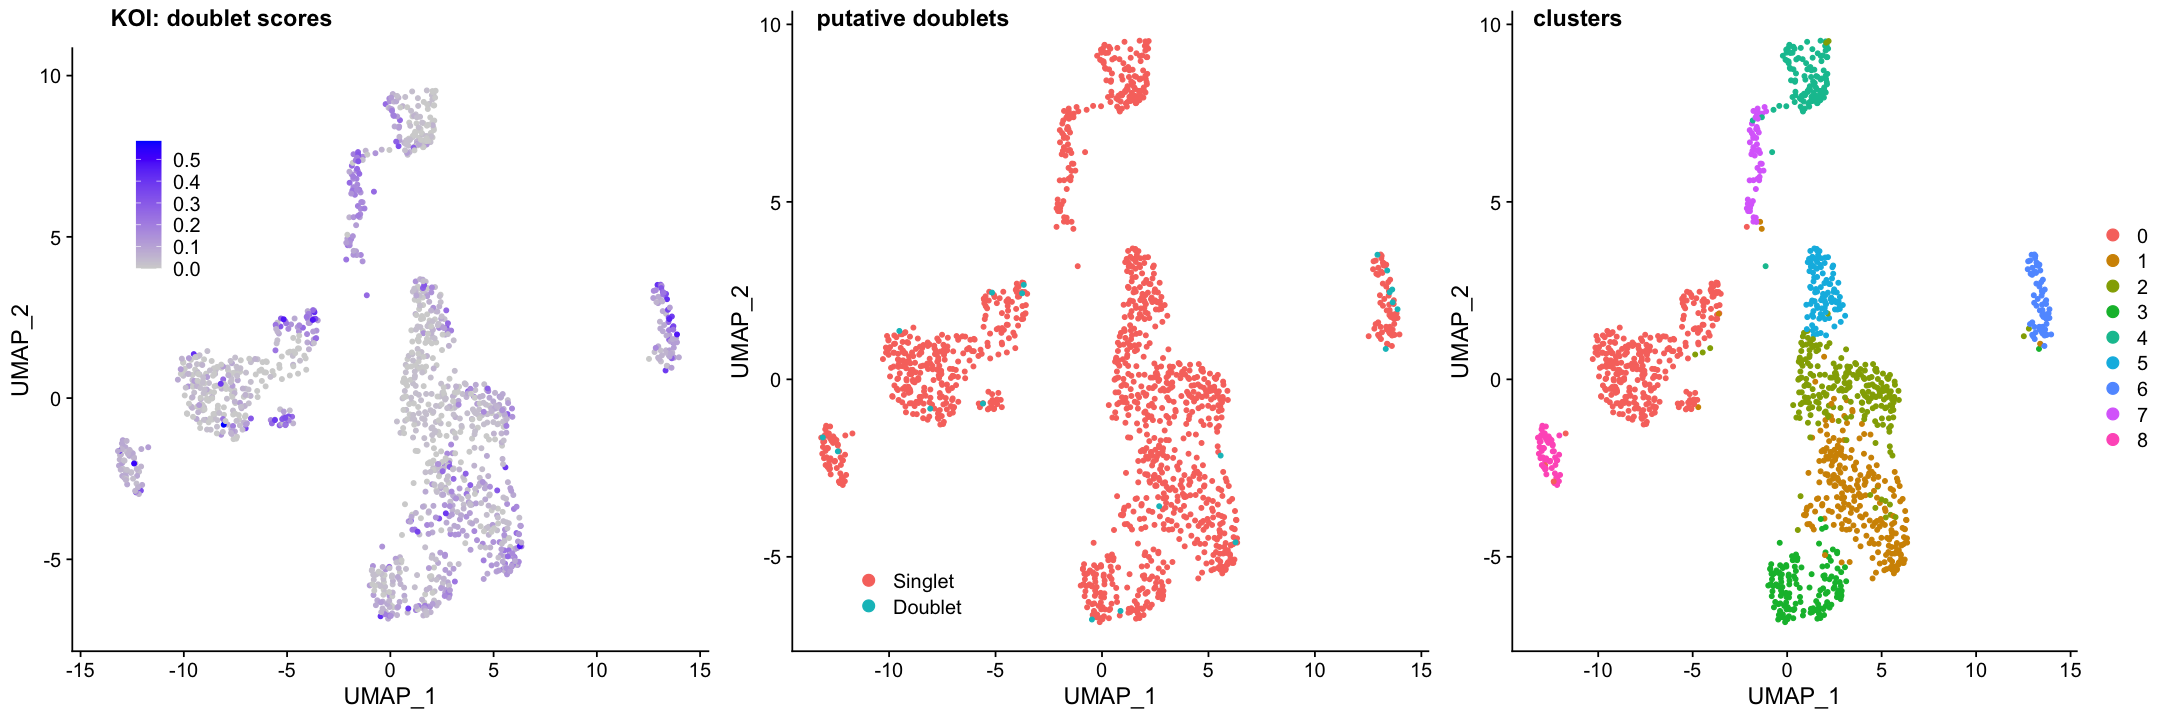

In [182]:
options(repr.plot.width=18, repr.plot.height=6)
plot_grid(
    FeaturePlot(koi, features = "doublet")+ggtitle("")+theme(legend.position = c(0.1,0.75)),
    DimPlot(koi, group.by="DF",order="Doublet")+theme(legend.position = c(0.1,0.1)),
    DimPlot(koi, group.by="RNA_snn_res.0.5"),
    labels=c("KOI: doublet scores","putative doublets","     clusters"),ncol=3
)

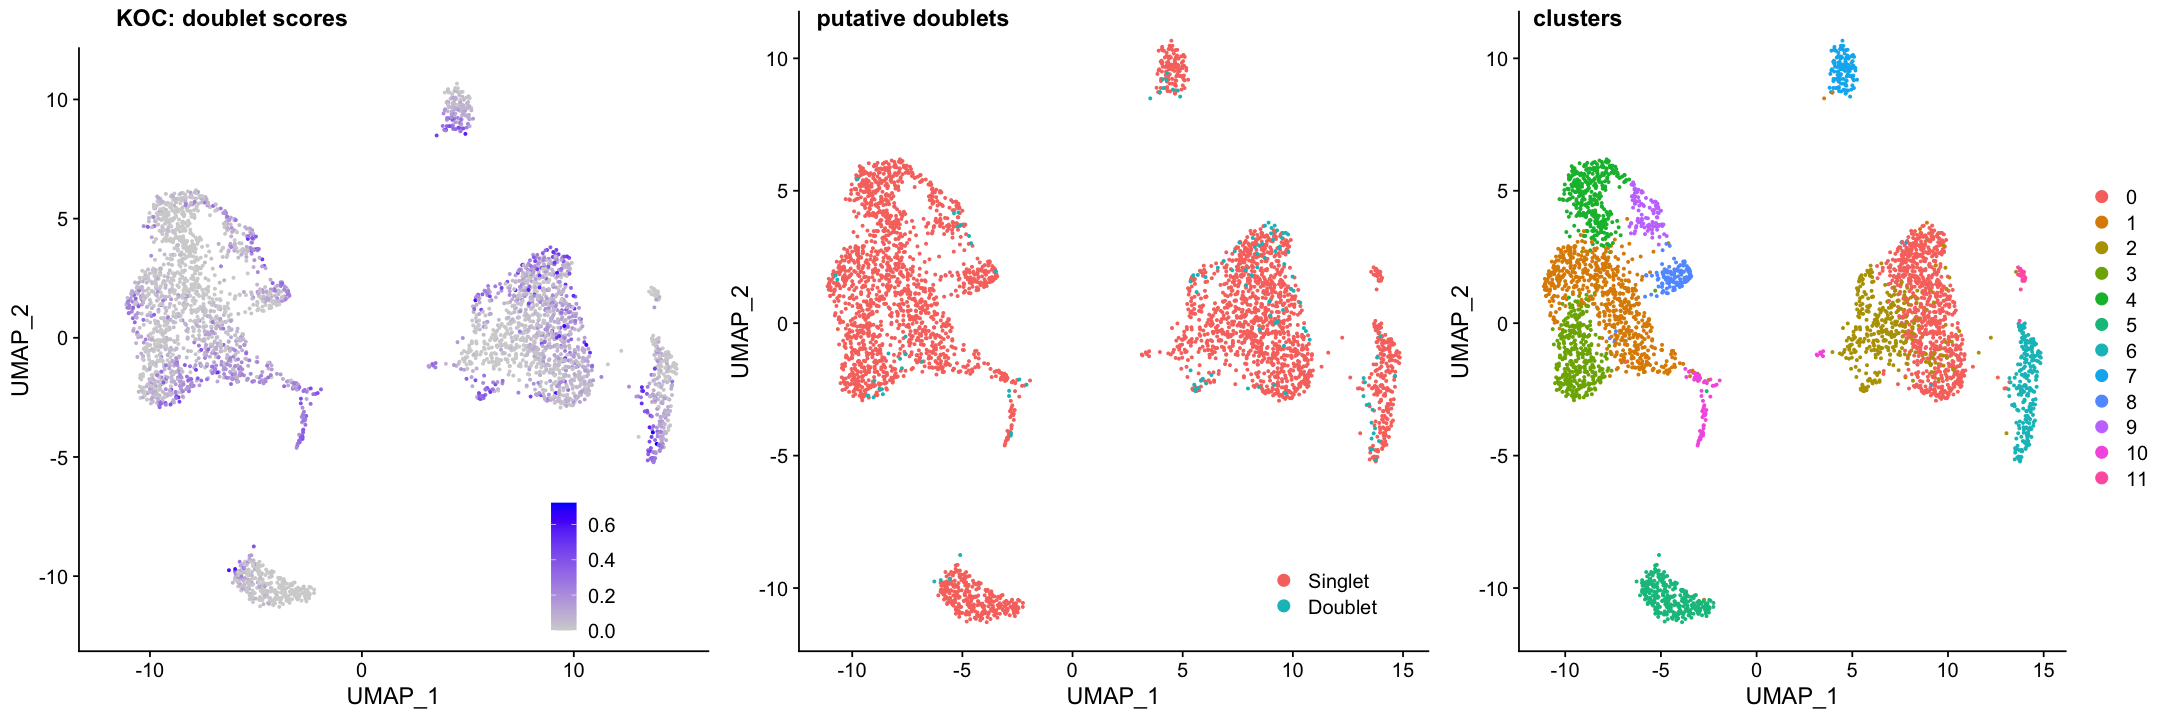

In [183]:
options(repr.plot.width=18, repr.plot.height=6)
plot_grid(
    FeaturePlot(koc, features = "doublet")+ggtitle("")+theme(legend.position = c(0.75,0.15)),
    DimPlot(koc, group.by="DF",order="Doublet")+theme(legend.position = c(0.75,0.1)),
    DimPlot(koc, group.by="RNA_snn_res.0.5"),
    labels=c("KOC: doublet scores","putative doublets","     clusters"),ncol=3
)

# Load the integrated dataset and add the doublet information

In [199]:
tic()
immune.combined<-readRDS(file = "/Users/yzhou14/Data_local/20200627_scRNAseq_analysis/Colon_0.6_0627.RDS")
toc()

6.62 sec elapsed


In [206]:
doublet.metadata<-rbind(
    wti[[c("DF","doublet")]],
    wtc[[c("DF","doublet")]],
    koi[[c("DF","doublet")]],
    koc[[c("DF","doublet")]]
)

In [207]:
library(dplyr)
old.metadata<-immune.combined[[]]

new.metadata<-left_join(
    old.metadata %>% mutate(bc=rownames(old.metadata)),
    doublet.metadata %>% mutate(bc=rownames(doublet.metadata)),
    by='bc'
)
rownames(new.metadata)<-new.metadata$bc

immune.combined@meta.data<-new.metadata

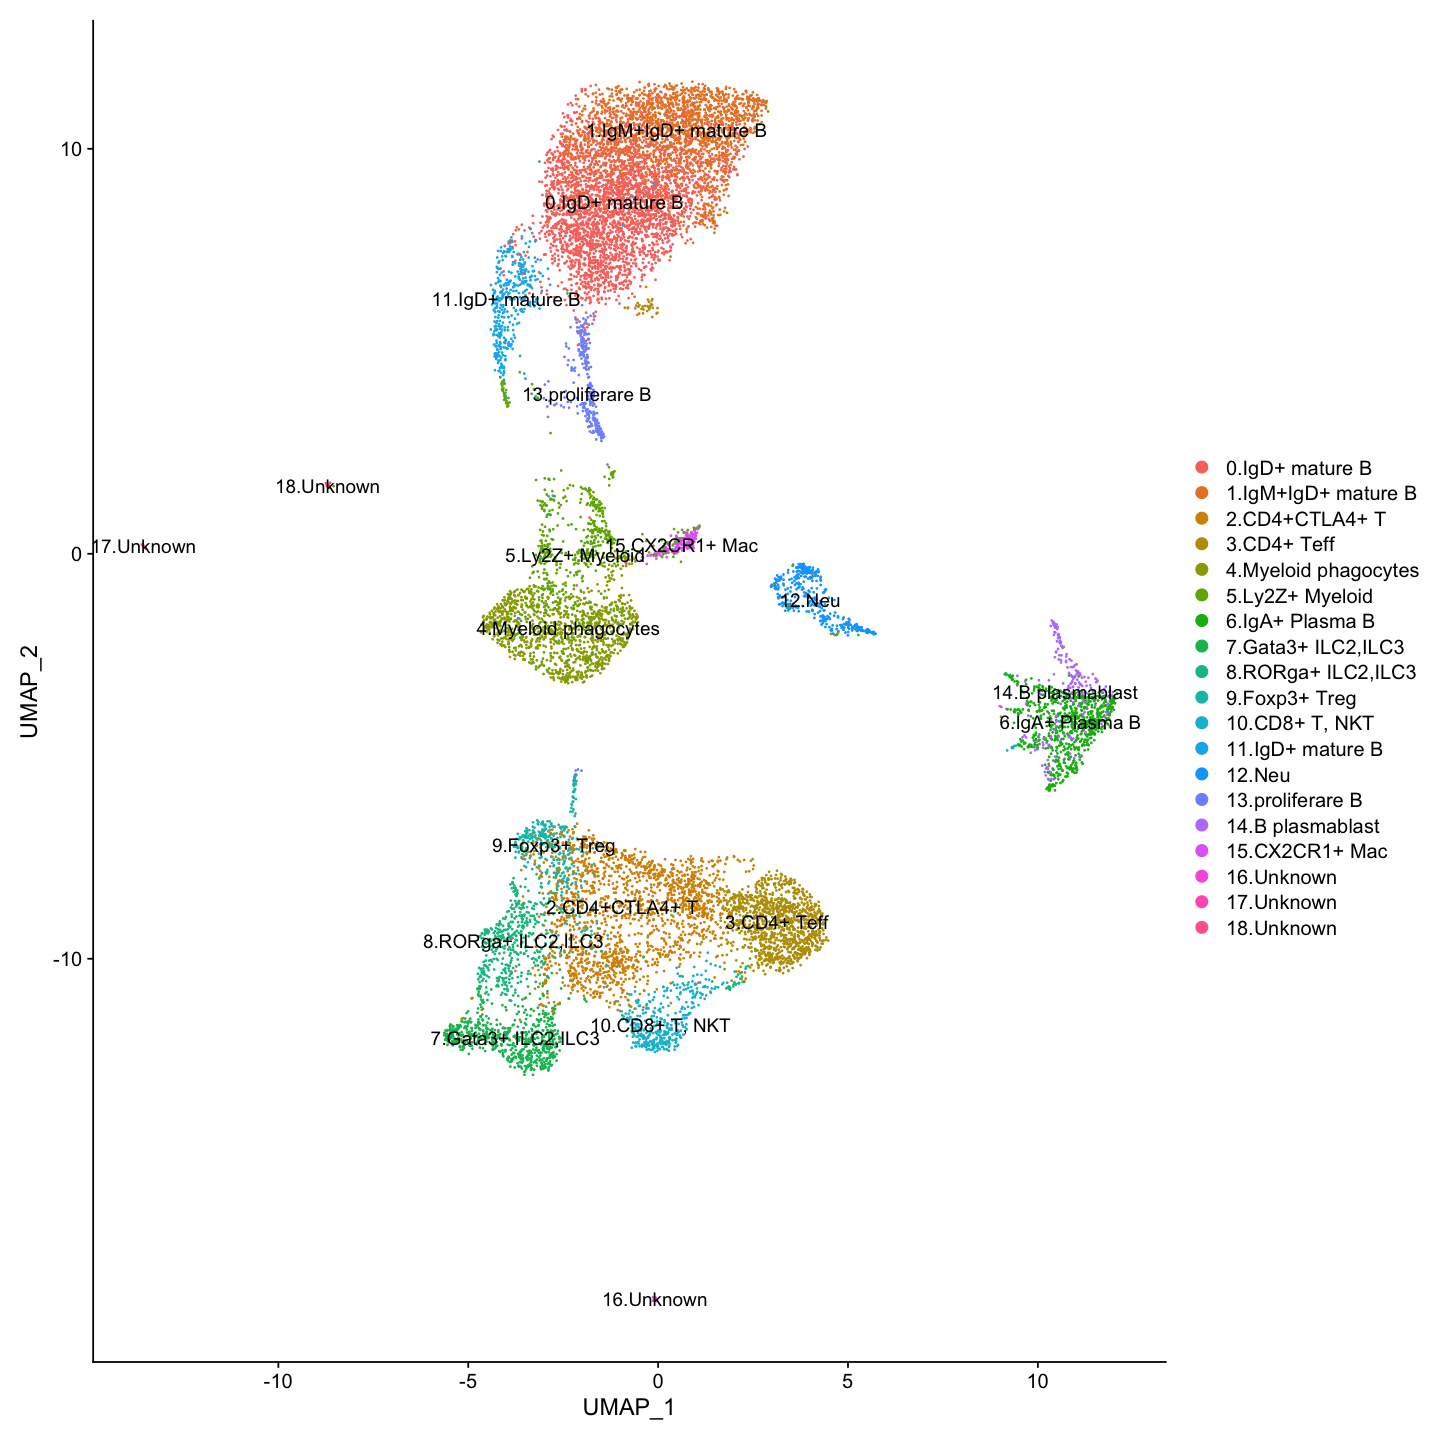

In [208]:
options(repr.plot.width=12, repr.plot.height=12)
DimPlot(immune.combined, group.by="celltype0627", label=T)

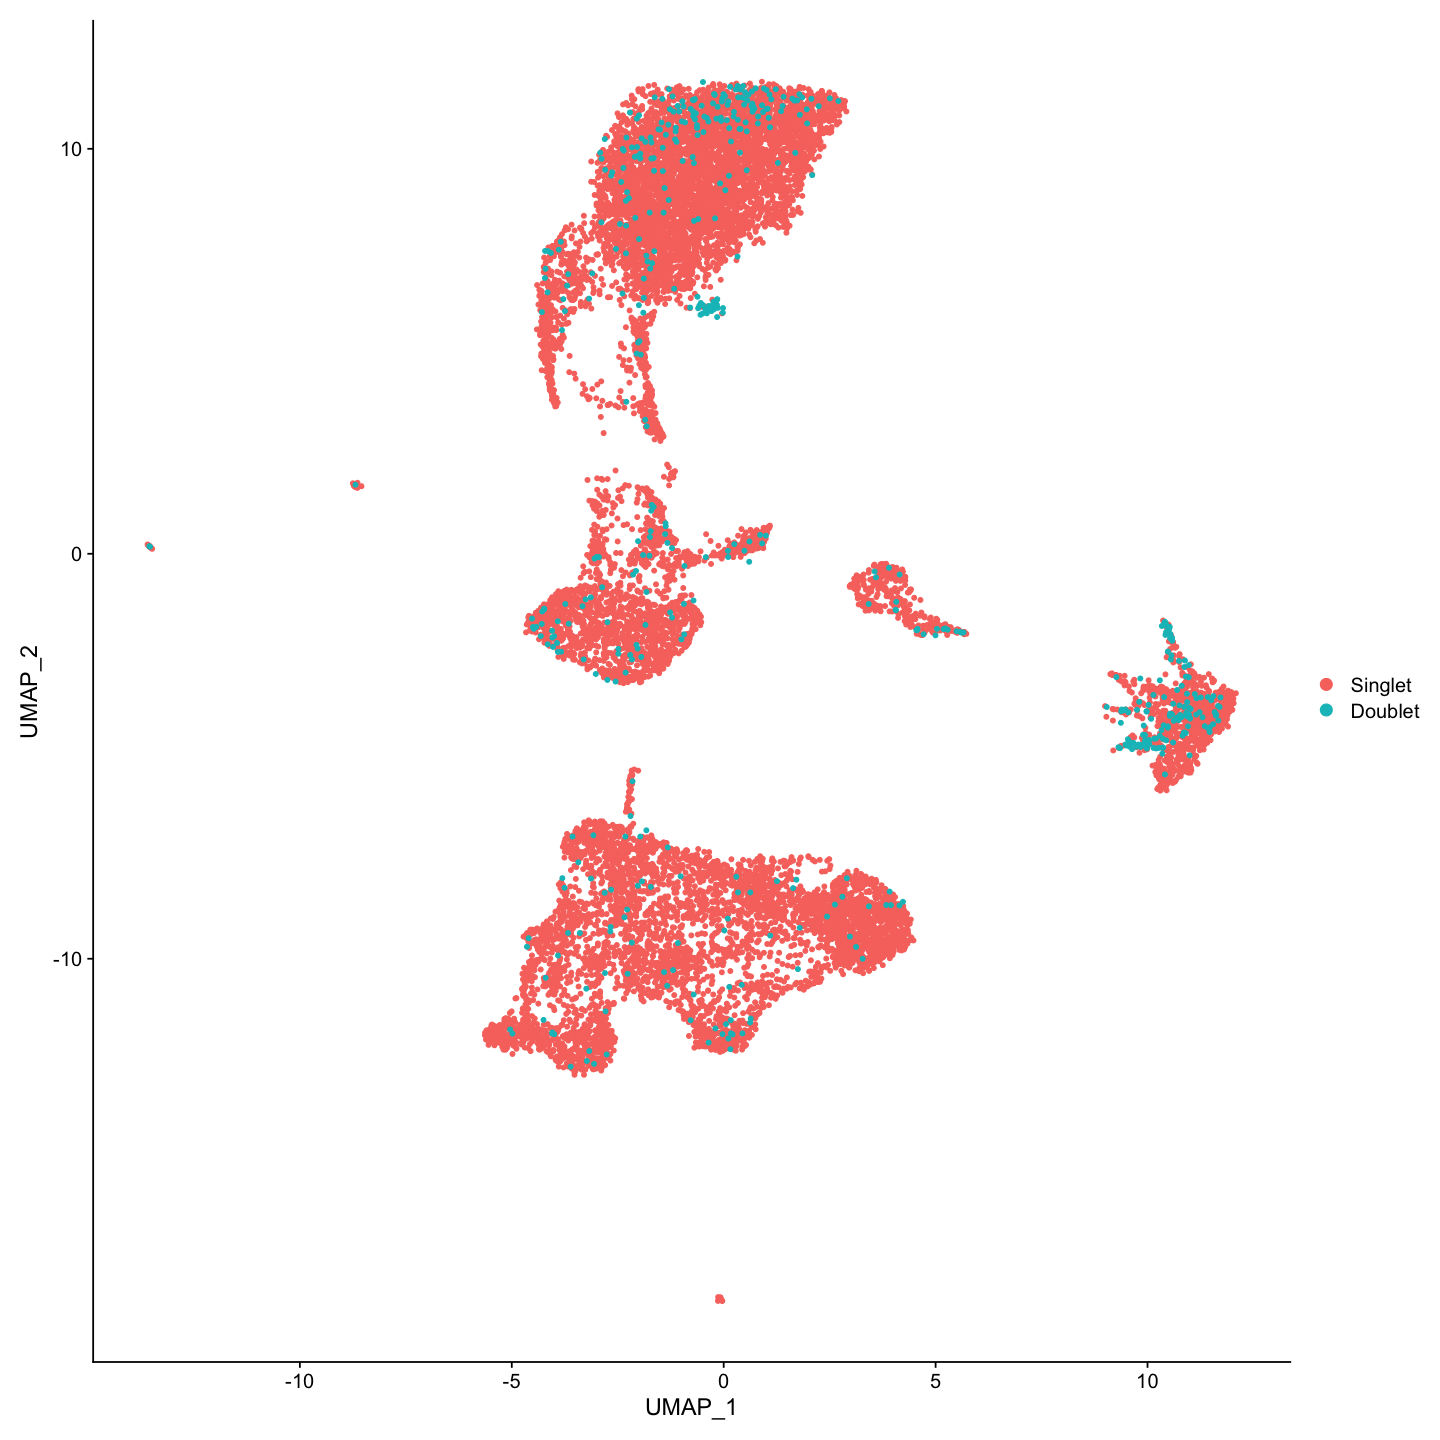

In [209]:
options(repr.plot.width=12, repr.plot.height=12)
DimPlot(immune.combined, group.by="DF", pt.size=1, order="Doublet")

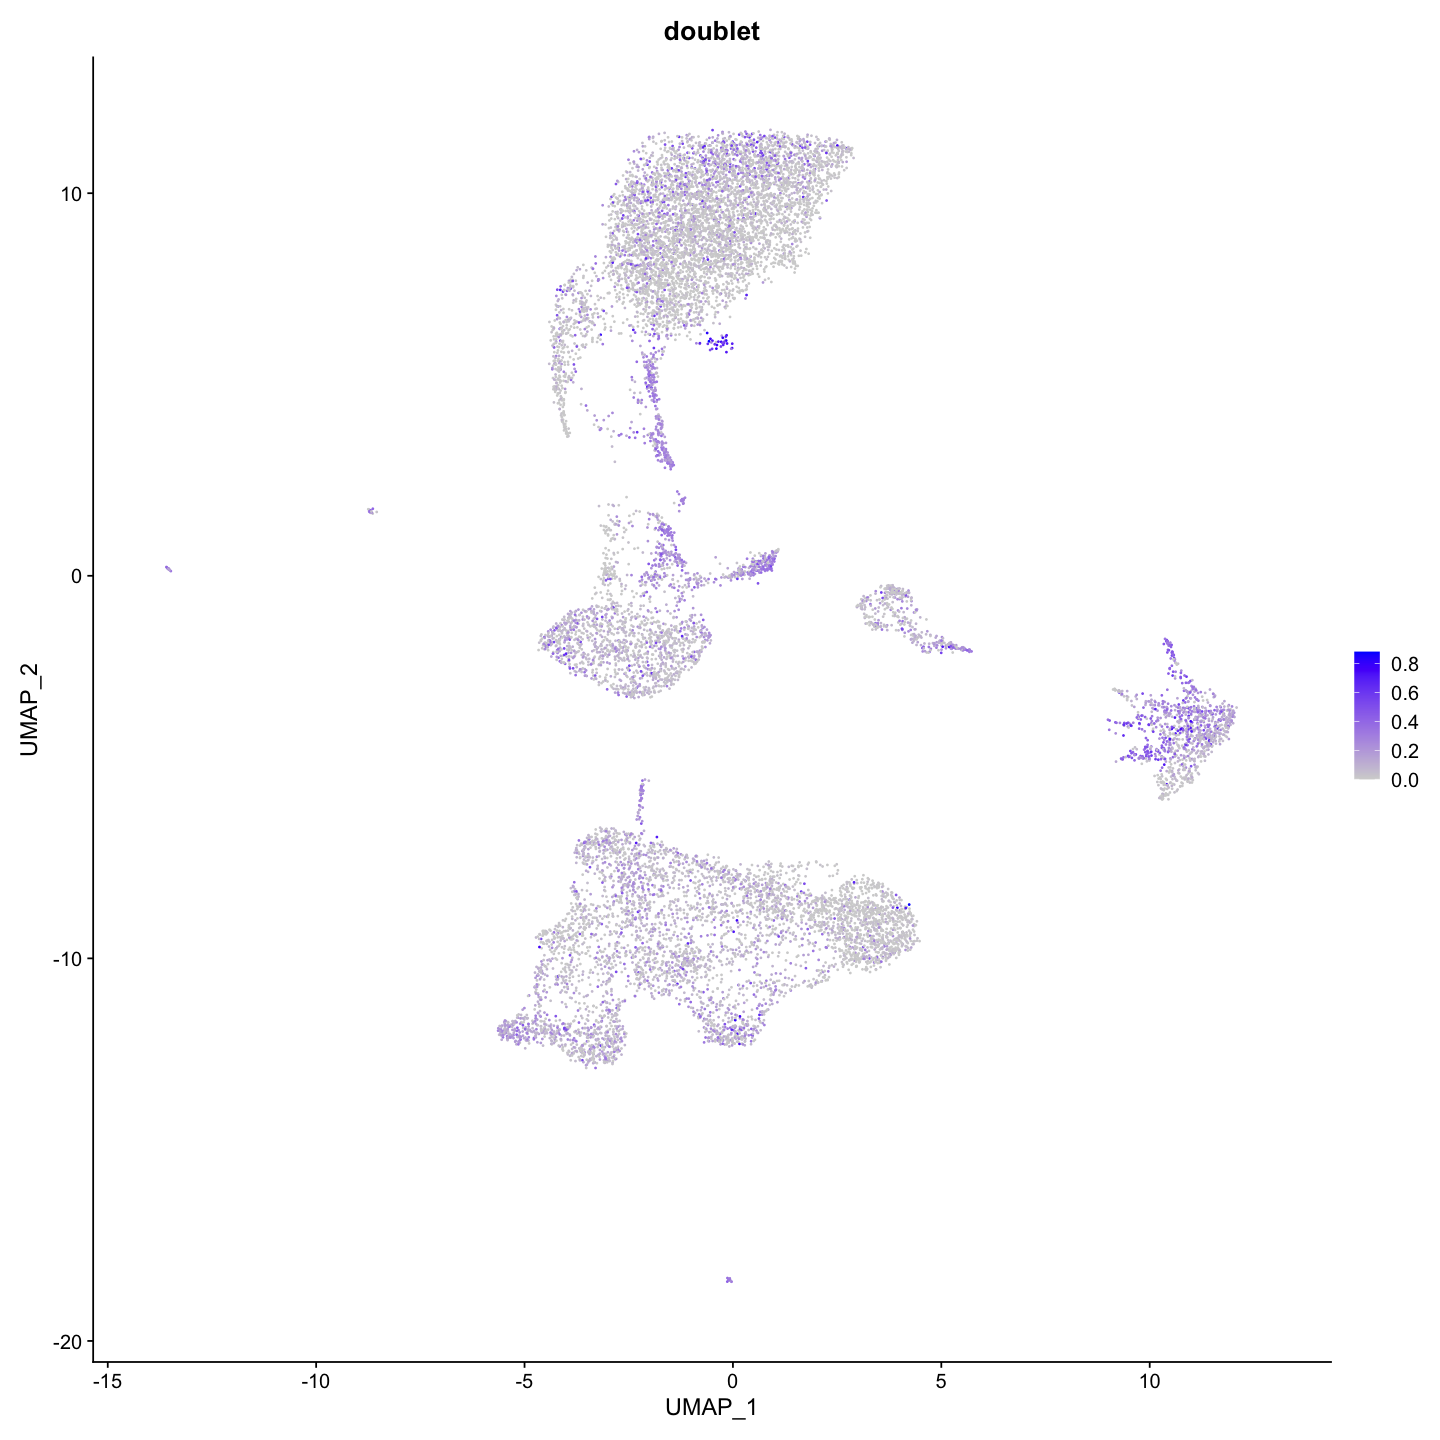

In [210]:
options(repr.plot.width=12, repr.plot.height=12)
FeaturePlot(immune.combined, features="doublet")

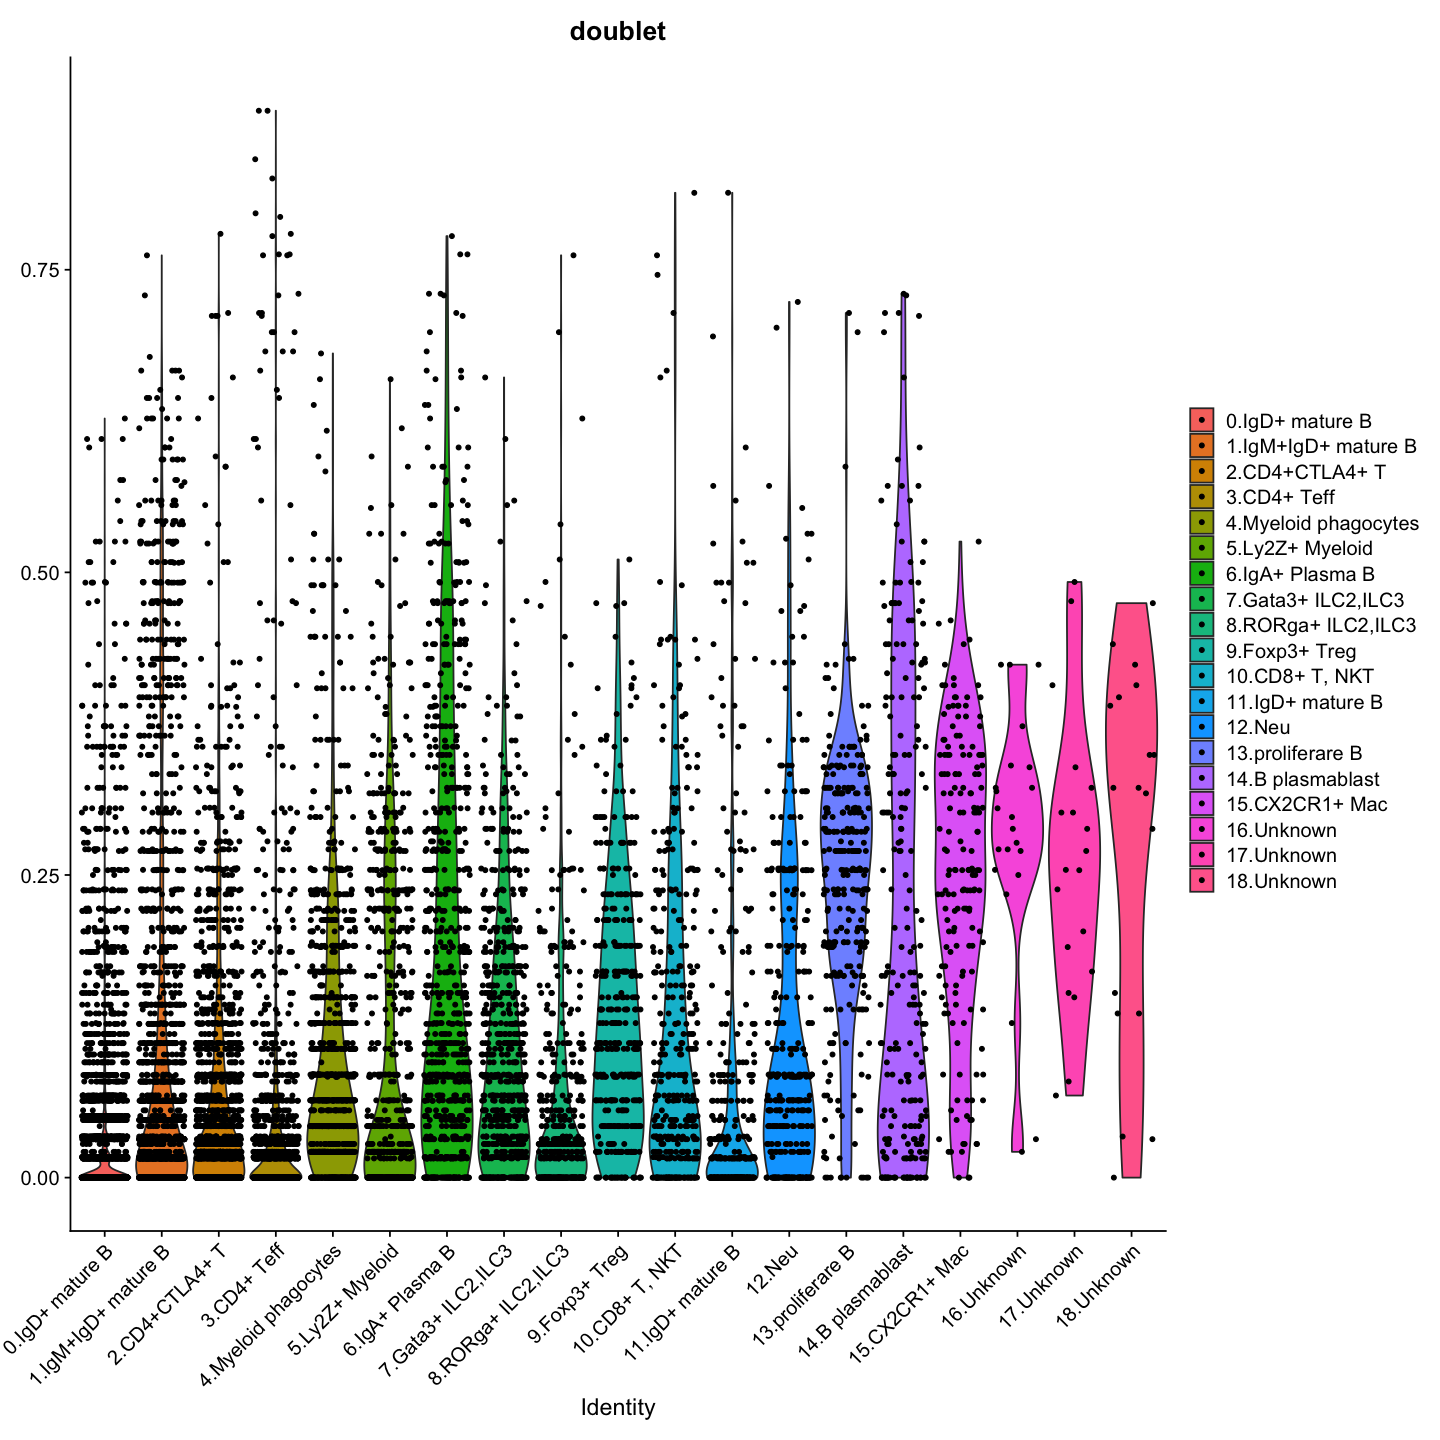

In [212]:
VlnPlot(immune.combined, features = "doublet", group.by = "celltype0627")

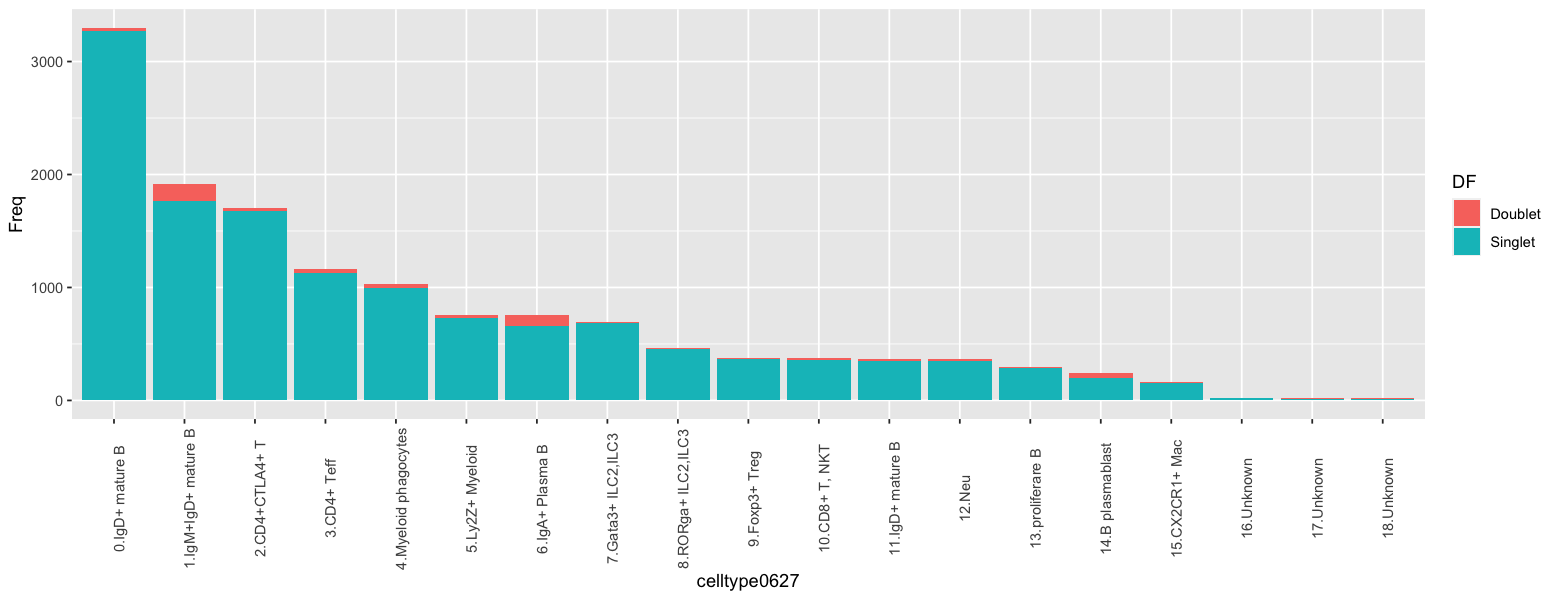

In [243]:
options(repr.plot.height=5, repr.plot.width=13)

dbldata=as.data.frame(table(immune.combined[[c("celltype0627","DF")]]))
 
# Stacked
ggplot(dbldata, aes(fill=DF, y=Freq, x=celltype0627)) + 
    geom_bar(position="stack", stat="identity")+ theme(axis.text.x = element_text(angle = 90)) 

In [259]:
tic()
save(immune.combined, file="Colon_0.6_0722.RDS",compress=T)
toc()

102.705 sec elapsed
